<h2>Imports</h2>

In [1]:
import os
import numpy as np
import torch
from collections import namedtuple
import csv
import re
from corpus import CornellMovieCorpus, Vocabulary
from rnn import Encoder, Decoder
from torch import optim
import torch.nn as nn
from matplotlib import pyplot as plt
from datetime import datetime
import random

/Users/darylramdin/opt/anaconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h2>Use the GPU if present</h2>

In [2]:
#Let's do the GPU stuff
device = torch.device('mps')
if (torch.cuda.is_available()):
   device = torch.device('cuda')
print(device)

mps


<h2>Create a Cornell Movie Corpus </h2>

In [3]:
corpus = CornellMovieCorpus()

Loading movie lines...
Converting conversation line numbers to text...
Creating exchange pairs


<h2>Let's look at some data</h2>

In [4]:
lines = list(corpus.movie_lines.items())
print("Lines\n")
for i in range(5):
    print(lines[i])

print("\nConversations\n")
for i in range(5):
    print(corpus.movie_convos[i])

print("\nExchanges\n")
for i in range(5):
    print(corpus.exchange_pairs[i])

Lines

('L1045', {'original_text': 'They do not!\n', 'prepped_text': 'they do not'})
('L1044', {'original_text': 'They do to!\n', 'prepped_text': 'they do to'})
('L985', {'original_text': 'I hope so.\n', 'prepped_text': 'i hope so'})
('L984', {'original_text': 'She okay?\n', 'prepped_text': 'she okay'})
('L925', {'original_text': "Let's go.\n", 'prepped_text': 'let s go'})

Conversations

['u0', 'u2', 'm0', "['L194', 'L195', 'L196', 'L197']"]
['u0', 'u2', 'm0', "['L198', 'L199']"]
['u0', 'u2', 'm0', "['L200', 'L201', 'L202', 'L203']"]
['u0', 'u2', 'm0', "['L204', 'L205', 'L206']"]
['u0', 'u2', 'm0', "['L207', 'L208']"]

Exchanges

('can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again', 'well i thought we d start with pronunciation if that s okay with you')
('well i thought we d start with pronunciation if that s okay with you', 'not the hacking and gagging and spitting part please')
('not the hacking and gaggin

<h2>Create the vocabulary</h2>

In [5]:
corpus.create_vocabulary()
lines = list(corpus.vocabulary.vocabulary.items())
for i in range(10):
    print(lines[i])

('<pad>', {'index': 0, 'count': 1})
('<sos>', {'index': 1, 'count': 1})
('<eos>', {'index': 2, 'count': 1})
('they', {'index': 3, 'count': 16996})
('do', {'index': 4, 'count': 22791})
('not', {'index': 5, 'count': 19555})
('to', {'index': 6, 'count': 80773})
('i', {'index': 7, 'count': 142514})
('hope', {'index': 8, 'count': 1023})
('so', {'index': 9, 'count': 13518})


<h2>Create Encoders and Decoders</h2>

In [6]:
sizeof_embedding = 256
sizeof_vocab = corpus.vocabulary.len

encoder = Encoder(sizeof_vocab, sizeof_embedding)
decoder = Decoder(sizeof_embedding, sizeof_vocab)


<h2>Let's setup our trainer</h2>

In [7]:
number_of_epochs = 1000
print_interval = 10
batch_size = 10
teacher_forcing = 1
teacher_forcing_decay = 1e-03

encoder_optimizer = optim.Adam(encoder.parameters(),lr=1e-03)
decoder_optimizer = optim.Adam(decoder.parameters(),lr=1e-03)

criterion = nn.NLLLoss()

#Let's get a random exchange pair
epoch_loss = []
start_time = datetime.now()
for epoch in range(number_of_epochs):
    
    exchange_pair = corpus.get_random_exchange()
    # print("Exchange", exchange_pair)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_tensor, target_tensor = corpus.pairToTensor(exchange_pair)
    #print("Input tensor shape", input_tensor.shape, "target", target_tensor.shape)

    #Try this on the encoder
    #We need to initialise the hidden state
    hidden = torch.zeros(1,1,encoder.sizeof_embedding)

    encoder_output = []

    #Encode each word in the input tensor one word a time
    for wIDX in input_tensor:
        output, hidden = encoder(wIDX,hidden)
        #We also keep an array of the outputs
        encoder_output.append(output)

    # #The decoder accepts an input and the previous hidden start
    # #At the start, the first input is the SOS token and the 
    # #previous hidden state is the output of the encoder i.e. context vector

    int_t = corpus.wordToTensor(Vocabulary.SOS)
    hidden = encoder_output[len(encoder_output)-1]

    loss = 0
    

    # print("Target Tensor", target_tensor.shape)

    decoder_output = []
    
    for i in range(len(target_tensor)):
        if random.random() < teacher_forcing: int_t = target_tensor[i]
        
        output, hidden = decoder(int_t,hidden)
        #print("Output", output.shape, "Target", target_tensor[i].shape)
        loss += criterion(output,target_tensor[i])
        int_t = torch.argmax(output,dim=1)
            
    if epoch%print_interval == 0: 
        end_time = datetime.now()
        timediff = end_time - start_time
        print("Epoch", epoch, "Loss", loss.item()/len(target_tensor), "teacher_forcing", teach_forcing, "in",timediff.seconds, "seconds") 
        start_time = datetime.now()
        
    epoch_loss.append([epoch,loss.item()/len(target_tensor)])
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    teach_forcing = max(0,teach_forcing - (teacher_forcing_decay * teach_forcing)) #return 0 if negative


Epoch 0 Loss 10.708063761393229 in 0 seconds
Epoch 10 Loss 9.252339680989584 in 3 seconds
Epoch 20 Loss 2.380751132965088 in 3 seconds
Epoch 30 Loss 8.490923563639322 in 2 seconds
Epoch 40 Loss 8.025685628255209 in 2 seconds
Epoch 50 Loss 6.168494542439778 in 2 seconds
Epoch 60 Loss 1.4395154317220051 in 2 seconds
Epoch 70 Loss 1.8028071721394856 in 2 seconds
Epoch 80 Loss 3.142868995666504 in 2 seconds
Epoch 90 Loss 1.3201165199279785 in 2 seconds
Epoch 100 Loss 2.7825454076131186 in 2 seconds
Epoch 110 Loss 5.445898691813151 in 2 seconds
Epoch 120 Loss 5.812182744344075 in 2 seconds
Epoch 130 Loss 1.0869491895039876 in 2 seconds
Epoch 140 Loss 4.162670771280925 in 2 seconds
Epoch 150 Loss 3.945336023966471 in 2 seconds
Epoch 160 Loss 2.696675936381022 in 2 seconds
Epoch 170 Loss 1.6494299570719402 in 2 seconds
Epoch 180 Loss 2.1642394065856934 in 2 seconds
Epoch 190 Loss 4.915808995564778 in 2 seconds
Epoch 200 Loss 0.5530683994293213 in 2 seconds
Epoch 210 Loss 3.0755860010782876 in

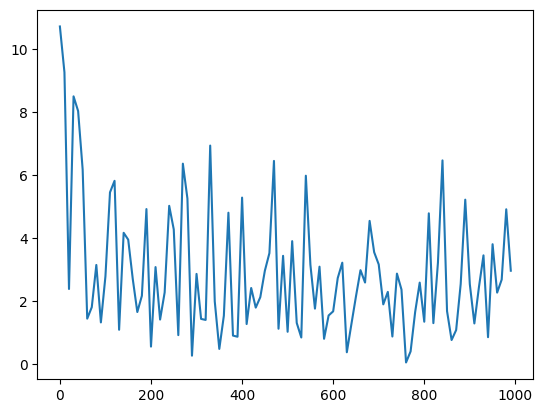

In [11]:
epoch_losses = np.array(epoch_loss)
plt.plot(epoch_losses[:,0][::10], epoch_losses[:,1][::10])
plt.show()

In [9]:
print(epoch_losses[:10,0][::2])

[0. 2. 4. 6. 8.]
